In [5]:
import numpy as np
from scipy.integrate import simps
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import os

%matplotlib inline

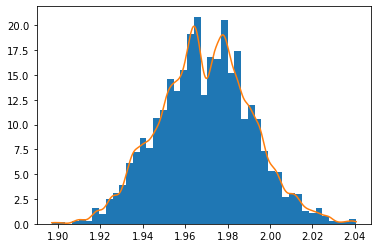

In [6]:
def test_kde(samples):
    kde = gaussian_kde(samples, bw_method=0.1)
    x_values = np.linspace(samples.min(), samples.max(), 2000)

    n, bins, _ = plt.hist(samples, bins=int(np.round(np.sqrt(len(samples)))), density=True)
    plt.plot(x_values, kde.pdf(x_values))
    plt.show()

chain = np.load("../output/BOSS_DR12_NGC_z1/samples/n30/cov_NERCOME/cov_NERCOME_30_results_v50.npy", allow_pickle=True)[()]
samples = chain["samples"][:,0]
test_kde(samples)

In [7]:
def estimate_kl_divergence(samples_p, samples_q, num_points=2000, bandwidth=0.1):
    # Fit Kernel Density Estimators for both distributions P and Q
    kde_p = gaussian_kde(samples_p, bw_method=bandwidth)
    kde_q = gaussian_kde(samples_q, bw_method=bandwidth)
    
    # Define a range over which to estimate the densities (covers both sample ranges)
    min_range = min(samples_p.min(), samples_q.min())
    max_range = max(samples_p.max(), samples_q.max())
    
    x_values = np.linspace(min_range, max_range, num_points)
    
    # Estimate densities for both P and Q on this range
    log_p = kde_p.logpdf(x_values)
    log_q = kde_q.logpdf(x_values)
    p = np.exp(log_p)
    
    kl_divergence = simps(p * (log_p - log_q), x_values)
    return kl_divergence

In [4]:
samples_p = np.random.normal(0, 1, size=2000)
samples_q = np.random.normal(1, 1, size=2000)

In [5]:
kl_div = estimate_kl_divergence(samples_p, samples_q, bandwidth="scott")
print(f"Estimated KL Divergence: {kl_div}") # Should be 0.5 for two Gaussians N(0,1) and N(1,1)

Estimated KL Divergence: 0.495002926690581


(4000, 2)


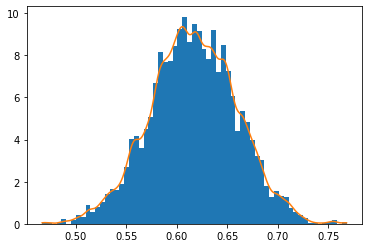

In [8]:
ref_chain = np.load("../output/BOSS_DR12_NGC_z1/samples/n2048/cov_sample/cov_sample_2048_results_v1.npy", allow_pickle=True)[()]
ref_samples = ref_chain["samples"]
print(ref_samples.shape)

test_kde(ref_samples[:,1])

In [9]:
estimates = [
    ['cov', 'sample', "Sample"],
    ['cov', 'shrinkage_emp', "Covariance shrinkage, target T^1 (empirical)"],
    ['cov', 'shrinkage_ana', "Covariance shrinkage, target T^2 (analytical)"],
    ['cov', 'NERCOME', "NERCOME"],
    ['pre', 'shrinkage_emp', "Precision shrinkage, target Pi_0^1 (empirical)"],
    ['pre', 'shrinkage_ana', "Precision shrinkage, target Pi_0^2 (analytical)"],
]
params = ["Bias", "Growth"]

In [11]:
# Exclude samples from matrix with negative eigenvalues (pre_18_18_shrinkage_ana_24_v50.matrix)
# Corresponding samples filename is pre_shrinkage_ana_24_results_v50.npy
fname_excl = "pre_shrinkage_ana_24_results_v50.npy"

for n in [2048, 30, 24]:
    print(f"For n={n} samples:")
    for estimate in estimates:
        mat_type = estimate[0]
        est_type = estimate[1]
        label = estimate[2]

        datapath = f"../output/BOSS_DR12_NGC_z1/samples/n{n}/{mat_type}_{est_type}/"
        filenames = [f for f in os.listdir(datapath) if not f.startswith('.')]
    
        KL_divs = [] # Kl divergences for linear bias (b) and growth rate (f)
        for k, filename in enumerate(filenames):
            if filename == fname_excl:
                print("Excluded ", filename)
                continue
            
            results = np.load(os.path.join(datapath, filename), allow_pickle=True)[()]
            samples = results["samples"]
            
            KL_divs.append([
                estimate_kl_divergence(samples[:,0], ref_samples[:, 0]),
                estimate_kl_divergence(samples[:,1], ref_samples[:, 1])
            ])
        
        KL_divs = np.array(KL_divs)
        
        if n == 2048:
            for j, param in enumerate(params):
                print(label, param, np.round(KL_divs[0, j], 3))
        else:
            med = np.median(KL_divs, axis=0)
            low = med - np.quantile(KL_divs, 0.16, axis=0)
            high = np.quantile(KL_divs, 0.84, axis=0) - med
    
            for j, param in enumerate(params):
                print(label, param, np.round(med[j], 2), np.round(low[j], 2), np.round(high[j], 2))
    
    print("\n")

For n=2048 samples:
Sample Bias 0.0
Sample Growth 0.0
Covariance shrinkage, target T^1 (empirical) Bias 0.014
Covariance shrinkage, target T^1 (empirical) Growth 0.008
Covariance shrinkage, target T^2 (analytical) Bias 0.009
Covariance shrinkage, target T^2 (analytical) Growth 0.012
NERCOME Bias 0.018
NERCOME Growth 0.018
Precision shrinkage, target Pi_0^1 (empirical) Bias 0.01
Precision shrinkage, target Pi_0^1 (empirical) Growth 0.006
Precision shrinkage, target Pi_0^2 (analytical) Bias 0.01
Precision shrinkage, target Pi_0^2 (analytical) Growth 0.013


For n=30 samples:
Sample Bias 0.51 0.4 1.11
Sample Growth 0.36 0.28 1.36
Covariance shrinkage, target T^1 (empirical) Bias 0.05 0.02 0.06
Covariance shrinkage, target T^1 (empirical) Growth 0.07 0.03 0.05
Covariance shrinkage, target T^2 (analytical) Bias 0.47 0.27 0.78
Covariance shrinkage, target T^2 (analytical) Growth 0.4 0.2 0.55
NERCOME Bias 0.54 0.41 1.25
NERCOME Growth 0.21 0.16 0.37
Precision shrinkage, target Pi_0^1 (empiric